# Step 1. Initialize environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Step 2. Import codes for training

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed,fc_units=[256,128,64]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.fc1=nn.Linear(state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x=F.relu(self.fc1(state))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return(x)
        
class Duel_QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed,fc_units=[256,128,64]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Duel_QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.fc1=nn.Linear(state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)
        self.fc5=nn.Linear(fc_units[2],1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x=F.relu(self.fc1(state))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x1=self.fc4(x)
        x2=self.fc5(x)
        return(x1+x2)

In [5]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
DEFAULT_PRIORITY=1e-2   # initialization value for priority

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, prioritized=False, Duel=False, Double=False,alpha=0, learning_rate=LR, gamma=GAMMA, tau=TAU):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            lr (float): learning rate for local network
            tau (float): learning rate for target network
            gamma (float): decay rate for future rewards
            prioritized (bollean): decide whether to use prioritized Q-Learning
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.lr=learning_rate
        self.tau=tau
        self.gamma=gamma
        self.prioritized=prioritized
        self.double = Double
        
        # Q-Network
        if Duel:
            self.qnetwork_local = Duel_QNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = Duel_QNetwork(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.priority=deque(maxlen=BUFFER_SIZE)
        if self.prioritized:
            self.alpha=alpha
        else:
            self.alpha=0# The default value is 0, which is the not prioritized case
            
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 1)
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        self.priority.append(DEFAULT_PRIORITY)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experience, index = self.memory.sample(self.priority,self.alpha)
                self.learn(experience, index, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """

        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, index, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            index : The index of selected experiences. Used to select and update priority
            gamma (float): discount factor
            
        """
        states, actions, rewards, next_states, dones= experiences

        self.optimizer.zero_grad()
        loss=0
        ## TODO: find the correct way to calculate the weights to make the update unbiased.
        ## Should: each experience times 1/(NP_i) to correct the bias introduced by P_i
        ## In the paper: 1/(NP_i)^beta. And normalize the weights so that the largest one is 1 (Not used here)
        
        # ------------------- calculate the weights ------------------- #
        ## If it's prioritized DQN, calculate the weights, otherwise, use 1
        if self.prioritized:
            w=np.array(self.priority)**self.alpha
            w=w/np.sum(w)
            w=w[index]
            w=1/(len(agent.memory)*w)
            w=torch.from_numpy(w)
        else:
            w=torch.ones(BATCH_SIZE)
        
        # ------------------- calculate the update  ------------------- #
        expected_rewards=self.qnetwork_local(states)
        expected_rewards=expected_rewards.gather(1, actions)
        with torch.no_grad():    
            expected_next_rewards = self.qnetwork_target(next_states)
            _, max_index = torch.max(expected_next_rewards, 1, keepdim=True)
            if self.double:
                expected_next_rewards_extra = self.qnetwork_local(next_states)
                _, max_index = torch.max(expected_next_rewards_extra, 1, keepdim=True)
            expected_next_rewards = expected_next_rewards.gather(1, max_index)
        real_rewards = rewards + self.gamma*(1-dones)*expected_next_rewards
        w = w.float().view(-1,1)
        loss = torch.sum(w*(expected_rewards-real_rewards).pow(2))/BATCH_SIZE
        loss.backward()
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
        
        # -------------------    update priority    ------------------- #
        ## Only update when the method is prioritized DQN
        if self.prioritized:
            priority=np.array(self.priority)
            values=abs((expected_rewards-real_rewards).detach().numpy()).reshape(-1)
            priority[index]=np.where(values>DEFAULT_PRIORITY,values,DEFAULT_PRIORITY)
            self.priority=deque(priority,maxlen=BUFFER_SIZE)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self,priority,alpha):
        """Randomly sample a batch of experiences from memory.
        
        Params
        ======
            priority: a vector records the priority for each experience
            alpha: to determine how much the priority should influence the probability. 
                p(sample i) ~ priority(sample i)**alpha
        """
        #Sample experiences with priority. First sample index, then pick corresponding experience
        prob=np.array(priority)**alpha
        prob=prob/np.sum(prob)#This makes it a probability
        index=np.random.choice(a=len(prob),size=self.batch_size,replace=False,p=prob)
        experiences = list(map(self.memory.__getitem__,index))
        
        #Extract information from memory unit and return
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones), index

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
from collections import deque

def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, finish=False):
    """
    Monitor the training process
    Params
    ======
        env, brain_name and agent are assumed to be defined elsewhere
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        finish (boolean): if True, the function finish n_episodes and return a smooth
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    means = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        means.append(np.mean(scores_window))
        print('\rEpisode {}\tEpisodic Score {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print(' ')
    #torch.save(agent.qnetwork_local.state_dict(), 'SQN_checkpoint.pth')
    return scores, means

# Step 3. Train the agent and see the result

In [7]:
import matplotlib.pyplot as plt

def plot_result(scores, means, suptitle):
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(suptitle)
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    average = np.mean(means, axis=0)
    error_bar = np.std(means, axis=0)/np.sqrt(15)
    upper = np.amax(means, axis=0)
    lower = np.amin(means, axis=0)
    ax1.plot(range(1000), average, label='Trajectory of moving average', color='yellow')
    ax1.plot(range(1000), upper, label='Upper bound', color='black')
    ax1.plot(range(1000), lower, label='Lower bound', color='black')
    ax1.fill_between(range(1000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax1.plot(range(1000), 13*np.ones(1000), label='Benchmark',color='gray')
    ax1.set_ylabel('Average')
    ax1.set_xlabel('Episode #')
    ax1.legend(loc=1)
    ax1.set_ylim([0, 20])
    ax1.set_title('Trajectory for moving average')
    
    average = np.mean(scores, axis=0)
    error_bar = np.std(scores, axis=0)/np.sqrt(15)
    upper = np.amax(scores, axis=0)
    lower = np.amin(scores, axis=0)
    ax2.plot(range(1000), average, label='Trajectory of episodic scores', color='yellow')
    ax2.fill_between(range(1000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax2.plot(range(1000), upper, label='Upper bound', color='black')
    ax2.plot(range(1000), lower, label='Lower bound', color='black')
    ax2.plot(range(1000), 13*np.ones(1000), label='Benchmark',color='gray')
    ax2.set_ylabel('Score')
    ax2.set_xlabel('Episode #')
    ax2.legend(loc=1)
    ax2.set_ylim([0, 30])
    ax2.set_title('Trajectory for episodic rewards')
    
    plt.show()

In [8]:
#This is the original DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, learning_rate=0.001, Duel=False, prioritized=False)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 0.00	Average Score: 0.61 
Episode 200	Episodic Score 6.00	Average Score: 3.06 
Episode 300	Episodic Score 11.00	Average Score: 6.27 
Episode 400	Episodic Score 13.00	Average Score: 7.85 
Episode 500	Episodic Score 14.00	Average Score: 11.60 
Episode 600	Episodic Score 12.00	Average Score: 13.67 
Episode 700	Episodic Score 11.00	Average Score: 12.74 
Episode 800	Episodic Score 17.00	Average Score: 13.08 
Episode 900	Episodic Score 15.00	Average Score: 13.42 
Episode 1000	Episodic Score 21.00	Average Score: 14.23 
Test No.2:
Episode 100	Episodic Score -1.00	Average Score: 0.35 
Episode 200	Episodic Score 1.00	Average Score: 3.05 
Episode 300	Episodic Score 5.00	Average Score: 5.88 
Episode 400	Episodic Score 16.00	Average Score: 7.51 
Episode 500	Episodic Score 11.00	Average Score: 11.42 
Episode 600	Episodic Score 11.00	Average Score: 11.54 
Episode 700	Episodic Score 16.00	Average Score: 12.59 
Episode 800	Episodic Score 11.00	Average Score: 13.50 

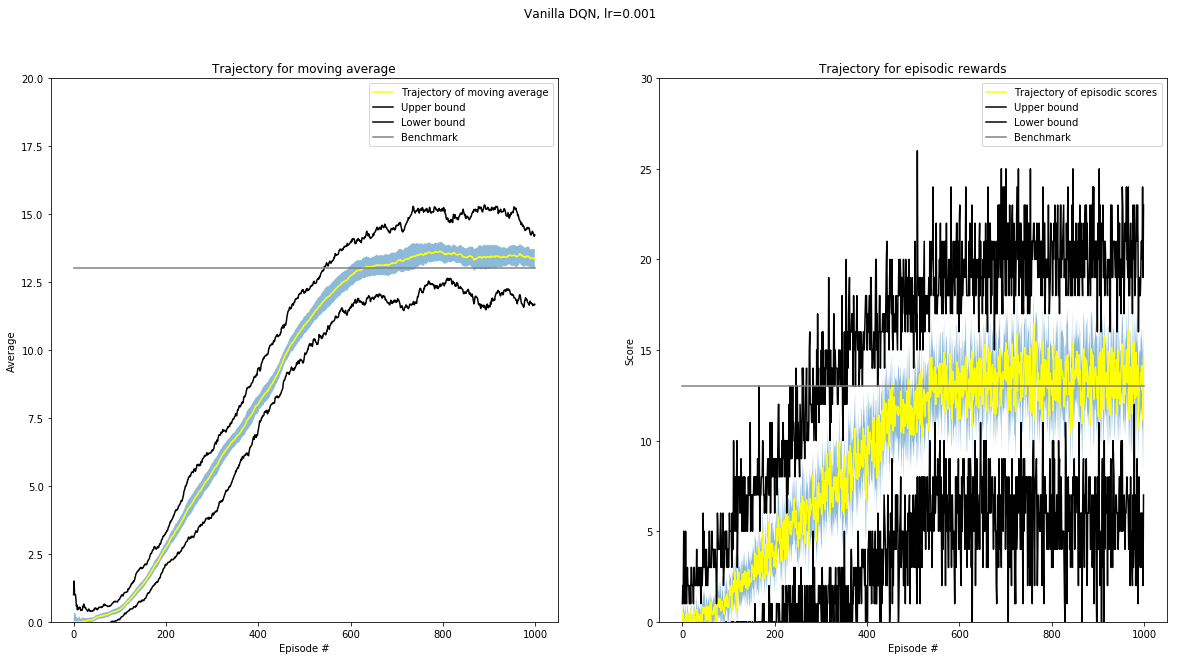

In [11]:
plot_result(scores, means, 'Vanilla DQN, lr=0.001')

In [12]:
#This is the original DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, learning_rate=0.0005)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 3.00	Average Score: 0.67 
Episode 200	Episodic Score 5.00	Average Score: 3.60 
Episode 300	Episodic Score 9.00	Average Score: 6.16 
Episode 400	Episodic Score 9.00	Average Score: 9.02 
Episode 500	Episodic Score 11.00	Average Score: 11.31 
Episode 600	Episodic Score 19.00	Average Score: 12.67 
Episode 700	Episodic Score 9.00	Average Score: 13.73 
Episode 800	Episodic Score 14.00	Average Score: 13.91 
Episode 900	Episodic Score 14.00	Average Score: 14.11 
Episode 1000	Episodic Score 9.00	Average Score: 13.30 
Test No.2:
Episode 100	Episodic Score 6.00	Average Score: 0.91 
Episode 200	Episodic Score 5.00	Average Score: 3.43 
Episode 300	Episodic Score 3.00	Average Score: 6.95 
Episode 400	Episodic Score 7.00	Average Score: 8.97 
Episode 500	Episodic Score 11.00	Average Score: 11.83 
Episode 600	Episodic Score 15.00	Average Score: 12.30 
Episode 700	Episodic Score 9.00	Average Score: 11.86 
Episode 800	Episodic Score 8.00	Average Score: 11.61 
Episode

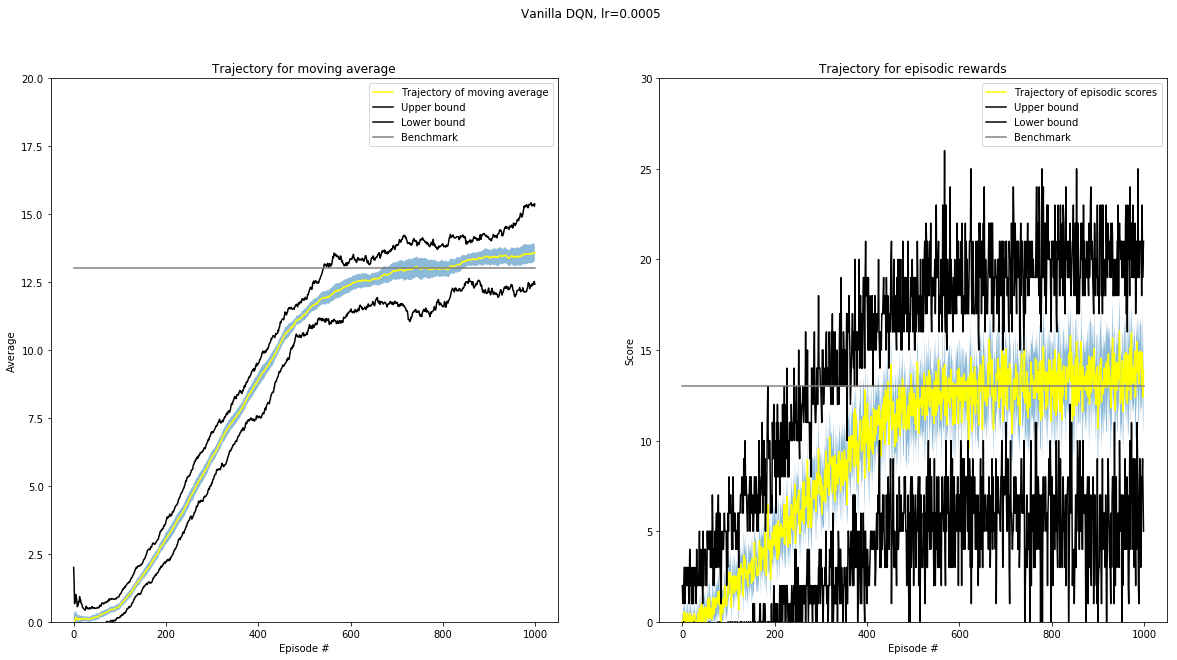

In [13]:
plot_result(scores, means, 'Vanilla DQN, lr=0.0005')

In [14]:
#This is the Duel-DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, Duel=True, learning_rate=0.001)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 1.00	Average Score: 0.47 
Episode 200	Episodic Score 2.00	Average Score: 2.33 
Episode 300	Episodic Score 5.00	Average Score: 4.82 
Episode 400	Episodic Score 8.00	Average Score: 8.55 
Episode 500	Episodic Score 13.00	Average Score: 12.05 
Episode 600	Episodic Score 15.00	Average Score: 13.87 
Episode 700	Episodic Score 12.00	Average Score: 13.87 
Episode 800	Episodic Score 16.00	Average Score: 13.16 
Episode 900	Episodic Score 18.00	Average Score: 14.76 
Episode 1000	Episodic Score 16.00	Average Score: 14.14 
Test No.2:
Episode 100	Episodic Score 1.00	Average Score: 0.39 
Episode 200	Episodic Score 1.00	Average Score: 2.40 
Episode 300	Episodic Score 5.00	Average Score: 5.26 
Episode 400	Episodic Score 18.00	Average Score: 8.95 
Episode 500	Episodic Score 11.00	Average Score: 11.50 
Episode 600	Episodic Score 17.00	Average Score: 13.72 
Episode 700	Episodic Score 15.00	Average Score: 14.37 
Episode 800	Episodic Score 13.00	Average Score: 14.57 
Ep

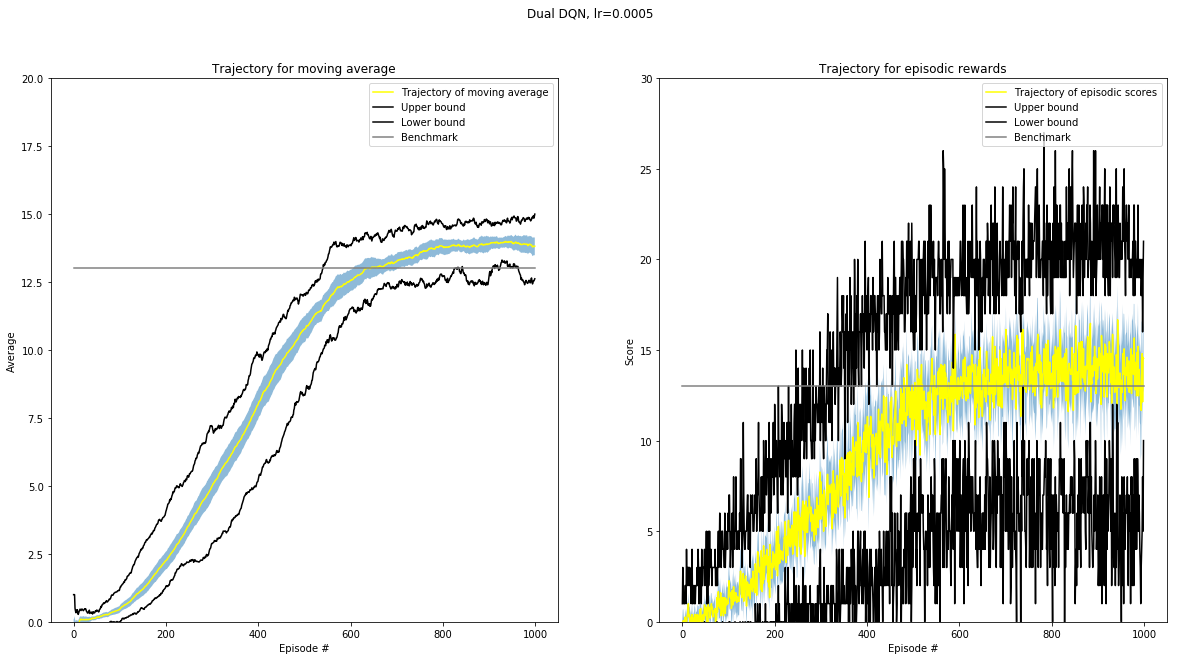

In [15]:
plot_result(scores, means, 'Duel DQN, lr=0.001')

In [16]:
#This is the Duel-DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, Duel=True, learning_rate=0.0005)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 1.00	Average Score: 0.18 
Episode 200	Episodic Score 1.00	Average Score: 1.90 
Episode 300	Episodic Score 5.00	Average Score: 5.12 
Episode 400	Episodic Score 17.00	Average Score: 9.50 
Episode 500	Episodic Score 13.00	Average Score: 12.02 
Episode 600	Episodic Score 17.00	Average Score: 12.91 
Episode 700	Episodic Score 9.00	Average Score: 14.27 
Episode 800	Episodic Score 12.00	Average Score: 13.83 
Episode 900	Episodic Score 16.00	Average Score: 14.23 
Episode 1000	Episodic Score 19.00	Average Score: 13.55 
Test No.2:
Episode 100	Episodic Score 0.00	Average Score: 0.34 
Episode 200	Episodic Score 7.00	Average Score: 2.28 
Episode 300	Episodic Score 3.00	Average Score: 6.39 
Episode 400	Episodic Score 15.00	Average Score: 9.49 
Episode 500	Episodic Score 12.00	Average Score: 12.03 
Episode 600	Episodic Score 7.00	Average Score: 12.76 
Episode 700	Episodic Score 11.00	Average Score: 12.49 
Episode 800	Episodic Score 16.00	Average Score: 13.83 
Epi

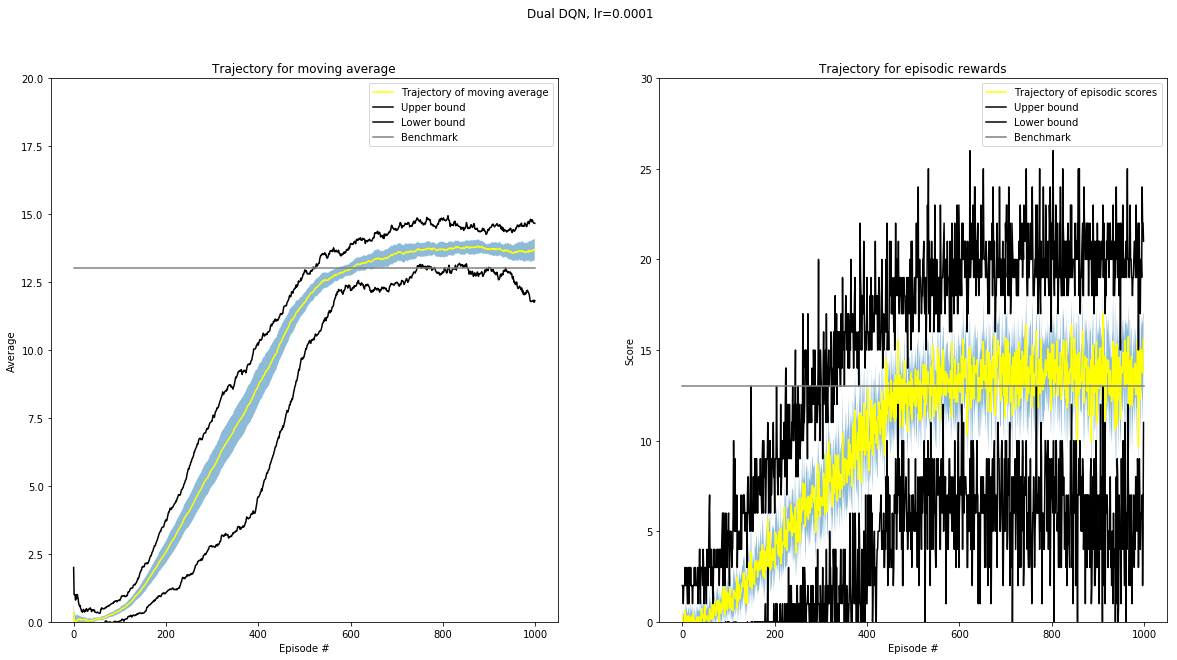

In [17]:
plot_result(scores, means, 'Duel DQN, lr=0.0005')

In [8]:
#This is the Double-DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, Double=True, learning_rate=0.001)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score -1.00	Average Score: 0.24 
Episode 200	Episodic Score 0.00	Average Score: 1.83 
Episode 300	Episodic Score 11.00	Average Score: 4.85 
Episode 400	Episodic Score 15.00	Average Score: 7.29 
Episode 500	Episodic Score 15.00	Average Score: 10.18 
Episode 600	Episodic Score 11.00	Average Score: 12.34 
Episode 700	Episodic Score 16.00	Average Score: 13.95 
Episode 800	Episodic Score 12.00	Average Score: 14.09 
Episode 900	Episodic Score 23.00	Average Score: 12.49 
Episode 1000	Episodic Score 18.00	Average Score: 14.13 
Test No.2:
Episode 100	Episodic Score 0.00	Average Score: 0.36 
Episode 200	Episodic Score 6.00	Average Score: 2.27 
Episode 300	Episodic Score 12.00	Average Score: 5.17 
Episode 400	Episodic Score 6.00	Average Score: 7.84 
Episode 500	Episodic Score 9.00	Average Score: 10.26 
Episode 600	Episodic Score 10.00	Average Score: 12.59 
Episode 700	Episodic Score 14.00	Average Score: 13.17 
Episode 800	Episodic Score 17.00	Average Score: 13.77 


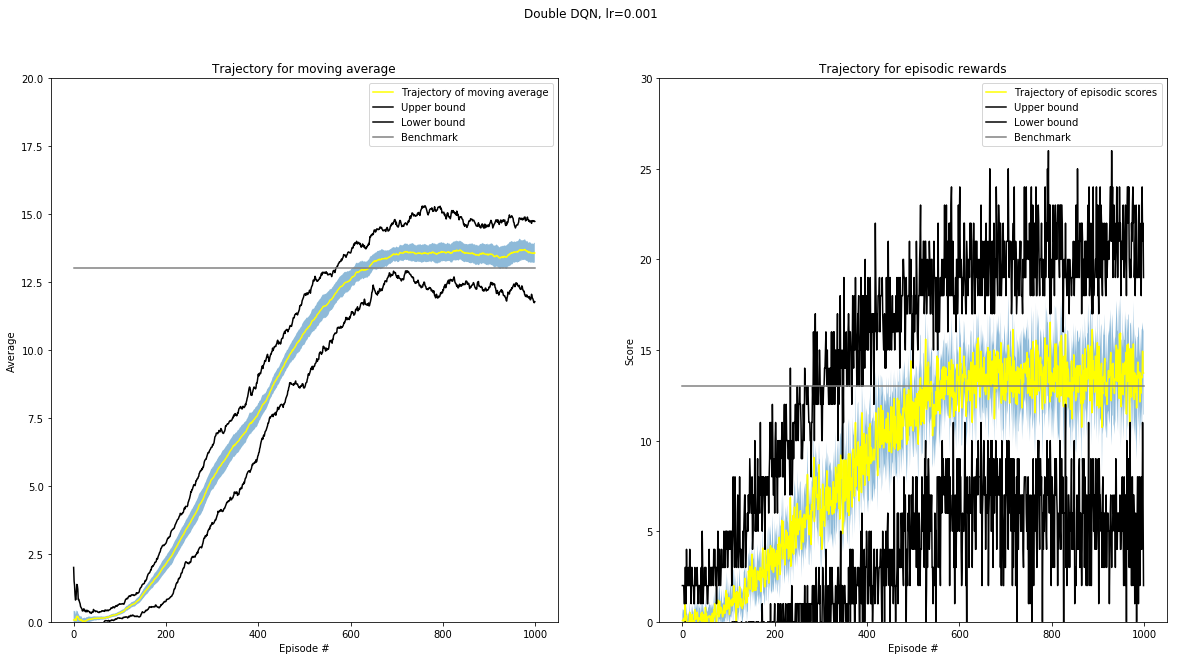

In [9]:
plot_result(scores, means, 'Double DQN, lr=0.001')

In [10]:
#This is the Double-DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, Double=True, learning_rate=0.0005)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 1.00	Average Score: 0.48 
Episode 200	Episodic Score 8.00	Average Score: 3.37 
Episode 300	Episodic Score 7.00	Average Score: 6.56 
Episode 400	Episodic Score 8.00	Average Score: 9.05 
Episode 500	Episodic Score 13.00	Average Score: 11.80 
Episode 600	Episodic Score 12.00	Average Score: 13.24 
Episode 700	Episodic Score 13.00	Average Score: 13.41 
Episode 800	Episodic Score 17.00	Average Score: 13.60 
Episode 900	Episodic Score 18.00	Average Score: 13.78 
Episode 1000	Episodic Score 7.00	Average Score: 14.38 
Test No.2:
Episode 100	Episodic Score 0.00	Average Score: 0.43 
Episode 200	Episodic Score -1.00	Average Score: 3.33 
Episode 300	Episodic Score 14.00	Average Score: 6.67 
Episode 400	Episodic Score 8.00	Average Score: 9.62 
Episode 500	Episodic Score 15.00	Average Score: 11.70 
Episode 600	Episodic Score 18.00	Average Score: 13.78 
Episode 700	Episodic Score 10.00	Average Score: 14.09 
Episode 800	Episodic Score 7.00	Average Score: 14.08 
Epi

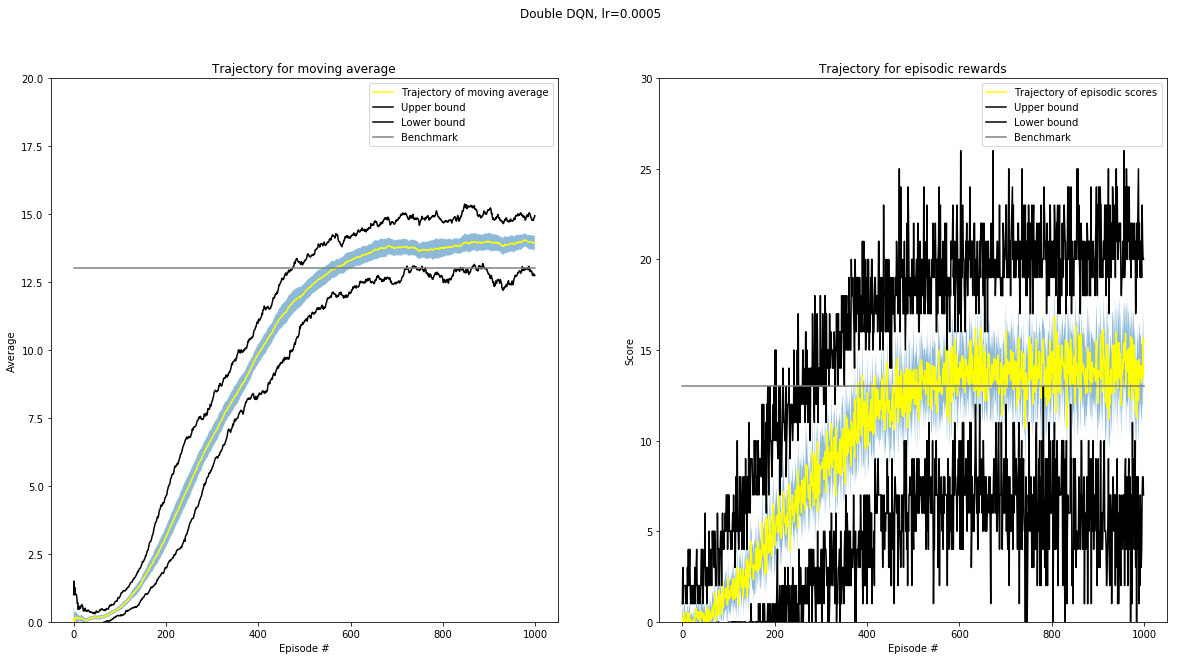

In [11]:
plot_result(scores, means, 'Double DQN, lr=0.0005')

In [8]:
#This is the Double-Duel-DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, Duel=True, Double=True, learning_rate=0.001)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 2.00	Average Score: 0.17 
Episode 200	Episodic Score 2.00	Average Score: 2.35 
Episode 300	Episodic Score 2.00	Average Score: 5.75 
Episode 400	Episodic Score 11.00	Average Score: 8.73 
Episode 500	Episodic Score 19.00	Average Score: 11.66 
Episode 600	Episodic Score 18.00	Average Score: 13.92 
Episode 700	Episodic Score 18.00	Average Score: 15.07 
Episode 800	Episodic Score 20.00	Average Score: 15.75 
Episode 900	Episodic Score 15.00	Average Score: 15.84 
Episode 1000	Episodic Score 23.00	Average Score: 15.48 
Test No.2:
Episode 100	Episodic Score -2.00	Average Score: 0.51 
Episode 200	Episodic Score 7.00	Average Score: 1.95 
Episode 300	Episodic Score 11.00	Average Score: 6.06 
Episode 400	Episodic Score 11.00	Average Score: 9.01 
Episode 500	Episodic Score 8.00	Average Score: 10.51 
Episode 600	Episodic Score 16.00	Average Score: 12.29 
Episode 700	Episodic Score 9.00	Average Score: 13.06 
Episode 800	Episodic Score 10.00	Average Score: 12.92 
E

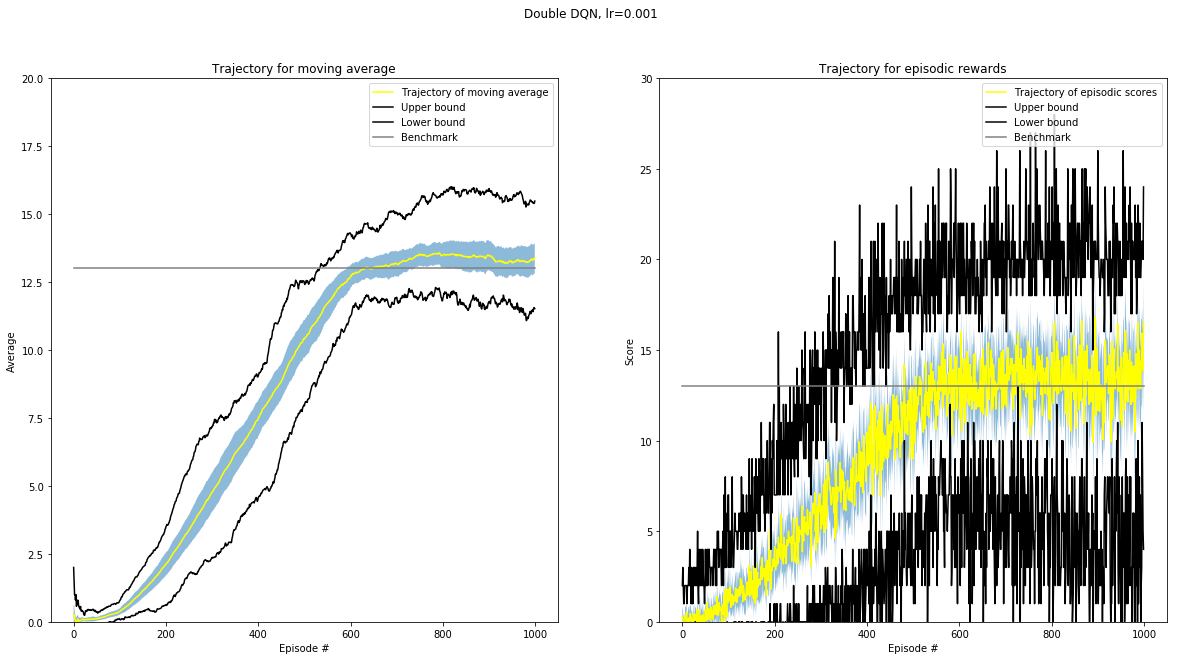

In [10]:
plot_result(scores, means, 'Double Duel DQN, lr=0.001')

In [8]:
#This is the Double-Duel-DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, Duel=True, Double=True, learning_rate=0.0005)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 2.00	Average Score: 0.60 
Episode 200	Episodic Score 3.00	Average Score: 2.74 
Episode 300	Episodic Score 15.00	Average Score: 6.78 
Episode 400	Episodic Score 7.00	Average Score: 9.28 
Episode 500	Episodic Score 14.00	Average Score: 13.11 
Episode 600	Episodic Score 14.00	Average Score: 14.24 
Episode 700	Episodic Score 16.00	Average Score: 13.25 
Episode 800	Episodic Score 12.00	Average Score: 12.65 
Episode 900	Episodic Score 5.00	Average Score: 13.28 
Episode 1000	Episodic Score 14.00	Average Score: 13.66 
Test No.2:
Episode 100	Episodic Score 3.00	Average Score: 0.21 
Episode 200	Episodic Score 6.00	Average Score: 1.96 
Episode 300	Episodic Score 10.00	Average Score: 6.04 
Episode 400	Episodic Score 9.00	Average Score: 7.98 
Episode 500	Episodic Score 7.00	Average Score: 12.65 
Episode 600	Episodic Score 15.00	Average Score: 13.62 
Episode 700	Episodic Score 16.00	Average Score: 14.17 
Episode 800	Episodic Score 17.00	Average Score: 14.30 
Epi

Episode 800	Episodic Score 11.00	Average Score: 13.73 
Episode 900	Episodic Score 15.00	Average Score: 14.11 
Episode 1000	Episodic Score 11.00	Average Score: 13.18 


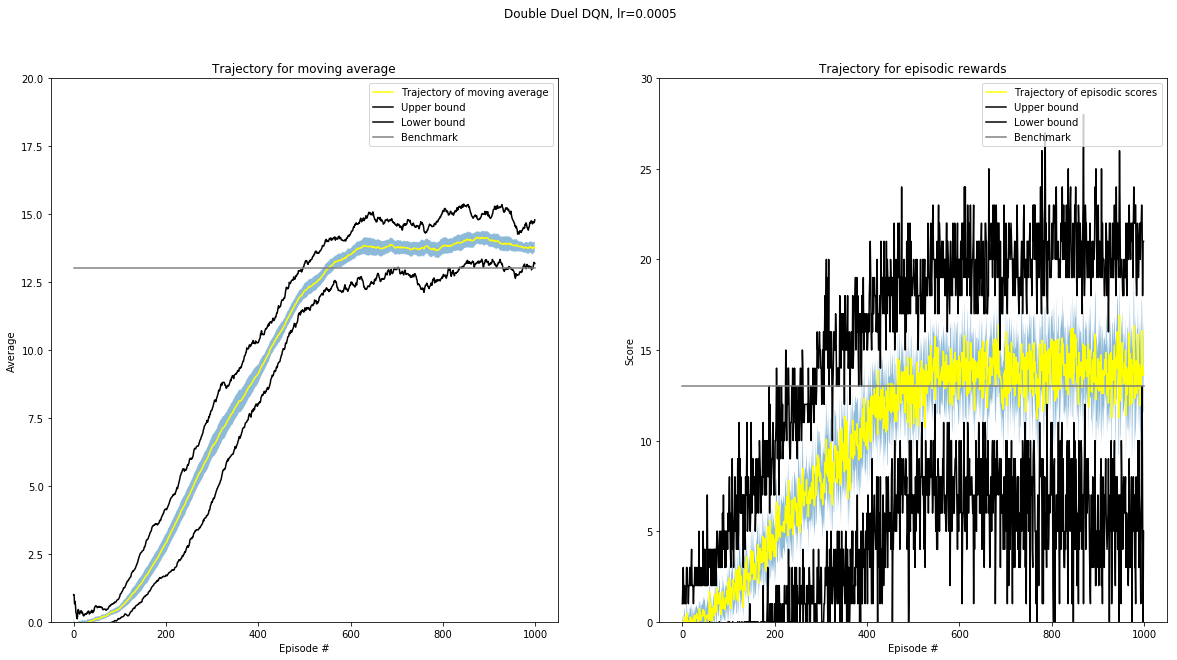

In [9]:
plot_result(scores, means, 'Double Duel DQN, lr=0.0005')

In [10]:
#This is the Prioritized DQN
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, seed=0, prioritized=True, learning_rate=0.0005)
    scores[i,:], means[i,:] = dqn()

Test No.1:
Episode 100	Episodic Score 1.00	Average Score: 0.26 
Episode 200	Episodic Score 5.00	Average Score: 1.68 
Episode 300	Episodic Score 5.00	Average Score: 4.57 
Episode 400	Episodic Score 12.00	Average Score: 7.63 
Episode 500	Episodic Score 10.00	Average Score: 10.77 
Episode 600	Episodic Score 12.00	Average Score: 12.87 
Episode 700	Episodic Score 11.00	Average Score: 13.44 
Episode 800	Episodic Score 14.00	Average Score: 13.80 
Episode 900	Episodic Score 10.00	Average Score: 14.32 
Episode 1000	Episodic Score 22.00	Average Score: 14.94 
Test No.2:
Episode 100	Episodic Score 1.00	Average Score: 0.42 
Episode 200	Episodic Score 10.00	Average Score: 3.13 
Episode 300	Episodic Score 8.00	Average Score: 5.91 
Episode 400	Episodic Score 14.00	Average Score: 9.59 
Episode 500	Episodic Score 3.00	Average Score: 11.77 
Episode 600	Episodic Score 19.00	Average Score: 12.34 
Episode 700	Episodic Score 16.00	Average Score: 13.25 
Episode 800	Episodic Score 18.00	Average Score: 13.19 
E

Episode 800	Episodic Score 15.00	Average Score: 13.26 
Episode 900	Episodic Score 13.00	Average Score: 13.61 
Episode 1000	Episodic Score 20.00	Average Score: 13.50 


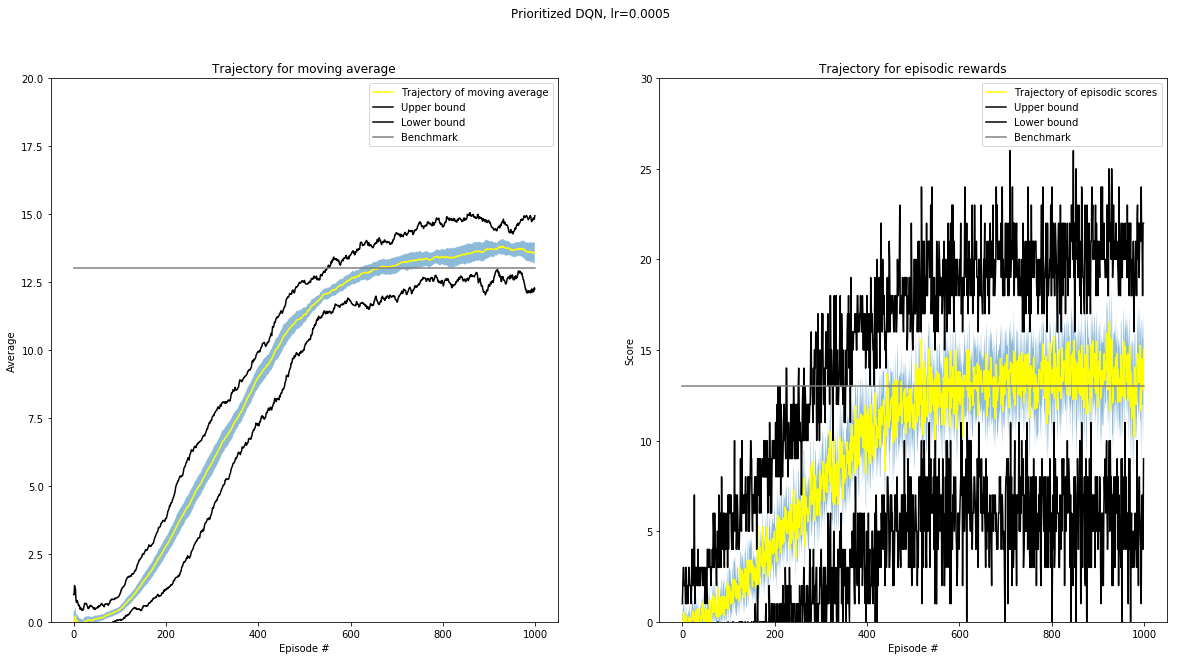

In [11]:
plot_result(scores, means, 'Prioritized DQN, lr=0.0005')